In [1]:
# IMPORT NEEDED LIBRARIES
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import numpy as np
from numpy import asarray
import seaborn as sns
import rioxarray as rxr
import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.enums import Resampling
import geopandas as gpd
import scipy
from scipy.stats import gaussian_kde
from scipy.stats import stats
from scipy.stats import mode
import seaborn as sns
import xarray as xr
import pandas as pd
import glob
import os
import fnmatch
import math
import statistics as st
from math import e
import matplotlib.ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
#from multispectral_functions import *

In [2]:
folder = '/mnt/nfs/lss/meerdink/data/backed_up/skzebarth/24_spring/'
S2_path = folder + 'S2B_MSIL2A_20230911T170859_N0509_R112_T15TUJ_20230911T214609.SAFE/S2B_MSIL2A_20230911T170859_N0509_R112_T15TUJ_20230911T214609.SAFE/GRANULE/L2A_T15TUJ_A034029_20230911T171258/IMG_DATA/R20m/'
S3_path = '/mnt/nfs/lss/meerdink/data/backed_up/skzebarth/24_spring/GP_GP_Final/Sentinel-3_BSL_RPJ.tif'
PS_path = '/mnt/nfs/lss/meerdink/data/backed_up/skzebarth/24_spring/GP_GP_Final/PS_mosaic.tif'
BSL = '/mnt/nfs/lss/meerdink/data/backed_up/skzebarth/23_BSL/big_spirit_lake.shp'
output = folder + 'GP_GP_Final/'
    red = PS_raster.sel(band=6)
    red_edge = PS_raster.sel(band=7)

In [107]:
def rgb(dir, 
        shape,
        sat,
        plot=False, 
        save=False):
    
    def normalize(array):
        """Normalizes numpy arrays into scale 0.0 - 1.0"""
        array_min, array_max = array.min(), array.max()
        return ((array - array_min)/(array_max - array_min))
    
    SP = gpd.read_file(shape)
    shape = SP.to_crs(32615)
    
    # Set RGB Bands,Sentinel-2 is red(B04), green(B03), blue(B02)
    if sat == 'S2':
       imageRed = glob.glob(dir + '/*B04*.jp2')
       imageGreen = glob.glob(dir + '/*B03*.jp2')
       imageBlue = glob.glob(dir + '/*B02*.jp2')
    
       imageRed_open = rxr.open_rasterio(imageRed[0], masked=True)
       imageBlue_open = rxr.open_rasterio(imageBlue[0], masked=True)
       imageGreen_open = rxr.open_rasterio(imageGreen[0], masked=True) 
        
       redClip = imageRed_open.rio.clip(shape.geometry.values, 
                                     shape.crs, 
                                     all_touched=False, 
                                     drop=True, 
                                     invert=False)
       blueClip = imageBlue_open.rio.clip(shape.geometry.values, 
                                       shape.crs, 
                                       all_touched=False, 
                                       drop=True, 
                                       invert=False)
       greenClip = imageGreen_open.rio.clip(shape.geometry.values, 
                                         shape.crs, 
                                         all_touched=False, 
                                         drop=True, 
                                         invert=False)
    
    # Normalize clip so rgb display is bright enough
       redn = normalize(redClip)
       bluen = normalize(blueClip)
       greenn = normalize(greenClip)

    # Pull band information from each array
       redData = redn.data[0,:,:]
       blueData = bluen.data[0,:,:]
       greenData = greenn.data[0,:,:]
    
    # Create and plot mask
    dataPlot = np.zeros((redData.shape[0],redData.shape[1],3))
    dataPlot[:,:,0] = redData
    dataPlot[:,:,1] = greenData
    dataPlot[:,:,2] = blueData
    dataPlotMask = np.ma.masked_where(np.isnan(dataPlot), dataPlot)
    #img = xr.Dataset()
    img = xr.DataArray(dataPlot,
                           dims = ('y', 'x', 'band'),
                           coords ={'y': redClip.coords['y'], 
                                    'x': redClip.coords['x'],
                                    'band': ["red", "green", "blue"]})
    
    
    # Transpose array for geotiff output
    out_img = img.transpose('band', 'y', 'x')
    out_img.rio.set_crs(shape.crs, inplace=True)

    if plot == True:
        
        shape.plot()
        plt.show()
    #Saving
    if save == True:
        outname = f"{sat}_rgb.tif"
        out_img.rio.to_raster(os.path.join(output, outname), driver='GTIFF')
    return out_img

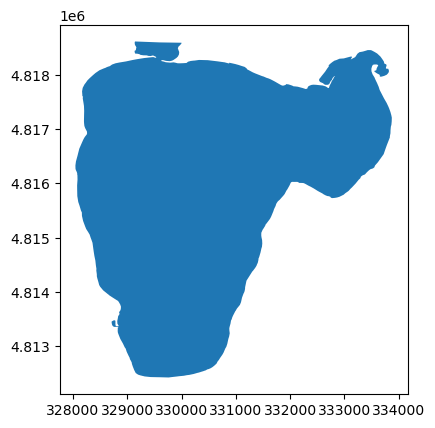

(array([1.28718e+05, 3.04060e+04, 1.47400e+03, 7.73000e+02, 4.52000e+02,
        3.54000e+02, 2.32000e+02, 2.11000e+02, 1.02000e+02, 4.60000e+01]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

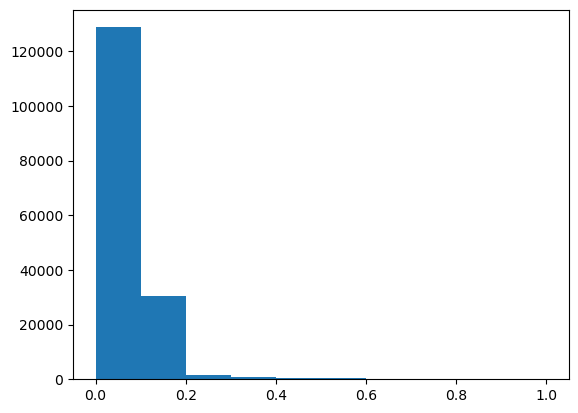

In [108]:
x = rgb(S2_path, BSL, 'S2', True, True)
x.plot()

EPSG:32615
[[[-- -- --]
  [-- -- --]
  [-- -- --]
  ...
  [-- -- --]
  [-- -- --]
  [-- -- --]]

 [[-- -- --]
  [-- -- --]
  [-- -- --]
  ...
  [-- -- --]
  [-- -- --]
  [-- -- --]]

 [[-- -- --]
  [-- -- --]
  [-- -- --]
  ...
  [-- -- --]
  [-- -- --]
  [-- -- --]]

 ...

 [[-- -- --]
  [-- -- --]
  [-- -- --]
  ...
  [-- -- --]
  [-- -- --]
  [-- -- --]]

 [[-- -- --]
  [-- -- --]
  [-- -- --]
  ...
  [-- -- --]
  [-- -- --]
  [-- -- --]]

 [[-- -- --]
  [-- -- --]
  [-- -- --]
  ...
  [-- -- --]
  [-- -- --]
  [-- -- --]]]


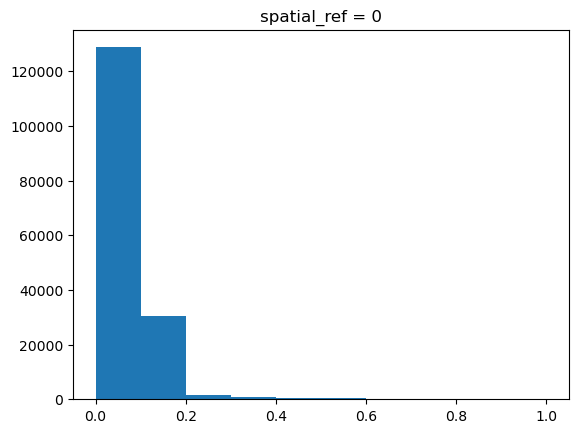

In [112]:


a = '/mnt/nfs/lss/meerdink/data/backed_up/skzebarth/24_spring/GP_GP_Final/S2_rgb.tif'
b = rio.open(a)
c = rxr.open_rasterio(a)
c.plot()
print(b.crs)
with rio.open(a) as src:
    
    r = src.read(3)*3
    g = src.read(2)*3
    b = src.read(1)*3
    
 
rgb = np.stack((r,g,b), axis=-1)
msk = np.ma.array(rgb, mask=np.isnan(rgb))

print(msk)

#print(rgb2)


#plt.imshow(msk)
#plt.show()